In [1]:
import pandas as pd
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,recall_score, precision_score, accuracy_score, f1_score, roc_curve,auc,precision_recall_curve
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Deep dive into random forest model for PNI

In [2]:
df = pd.read_csv('../data/PNI_001_cleaned.csv')
X = df.drop(['PNI','ID'],axis = 1)
y = df['PNI']

In [4]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 180)
model = RandomForestClassifier(n_estimators = 100, max_depth=25, min_samples_split=3,criterion = 'gini',random_state = 180)
cv = cross_validate(model, X = X, y = y, scoring = 'roc_auc', cv = cv_splitter)
cv

{'fit_time': array([2.02207398, 3.22928905, 2.69600511, 2.00003576, 2.00312495]),
 'score_time': array([0.02131796, 0.07972288, 0.01551509, 0.01269412, 0.02051306]),
 'test_score': array([0.76412873, 0.8042205 , 0.77270257, 0.76784205, 0.79567498]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [5]:
print('mean roc auc = {:.4f}'.format(np.mean(cv['test_score'])))
print('max roc auc = {:.4f}'.format(np.max(cv['test_score'])))

mean roc auc = 0.7809
max roc auc = 0.8042


## analysis of best fold

In [6]:
for fold, (train_index, test_index) in enumerate(cv_splitter.split(X, y)):
    if fold == 1:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestClassifier(n_estimators = 100, max_depth=25, min_samples_split=3,criterion = 'gini',random_state = 180)
        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)[:,1]

        print(roc_auc_score(y_test,y_pred))

0.8042205047699553


## output feature importance

In [9]:
df_importance = pd.DataFrame({'feature_name' :X.columns, 'importance': model.feature_importances_})

df_importance.sort_values(by = 'importance', ascending = False, inplace = True)

df_importance.to_csv('../results/PNI_feature_importance_0620.csv',index=False)

In [10]:
def plot_roc(fpr,tpr):
    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    return plt

Text(0.5, 1.0, 'predicted probability histogram')

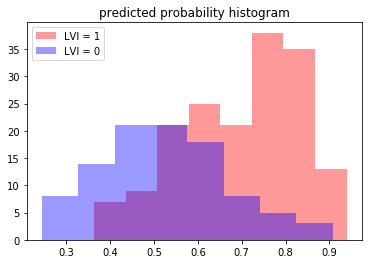

In [11]:
sns.distplot(y_pred[y_test==1], color = 'red', kde = False)
sns.distplot(y_pred[y_test==0], color = 'blue', kde = False)
plt.legend(['LVI = 1','LVI = 0'])
plt.title('predicted probability histogram')

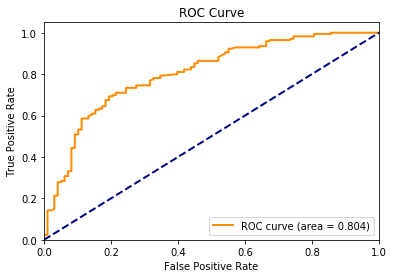

In [12]:
fpr, tpr, thres = roc_curve(y_test,y_pred)
plot_roc(fpr,tpr)
plt.savefig('results/outputs_0714/roc_curve_pni_rf.png')

In [13]:
precision, recall, thres = precision_recall_curve(y_test,y_pred)

Text(0.5, 0, 'recall')

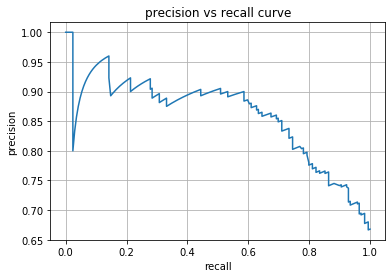

In [14]:
plt.plot(recall,precision)
plt.grid()
plt.title('precision vs recall curve')
plt.ylabel('precision')
plt.xlabel('recall')

In [15]:
threshold = np.linspace(.01,.99,200)

In [16]:
acc_list = []
f1_list = []
pre_list = []
rec_list = []

for thres in threshold:
    y_pred_label = np.where(y_pred > thres,1,0)
    
    acc_list.append(accuracy_score(y_test,y_pred_label))
    f1_list.append(f1_score(y_test,y_pred_label))
    pre_list.append(precision_score(y_test,y_pred_label))
    rec_list.append(recall_score(y_test,y_pred_label))
    

Text(0, 0.5, 'metrics')

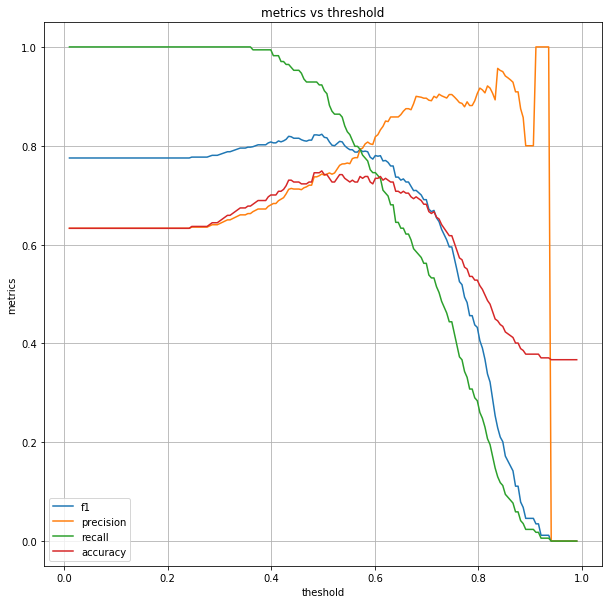

In [17]:
plt.figure(figsize = (10,10))
plt.grid()
plt.plot(threshold,f1_list)
plt.plot(threshold,pre_list)
plt.plot(threshold,rec_list)
plt.plot(threshold,acc_list)

plt.legend(['f1','precision','recall','accuracy'])
plt.title('metrics vs threshold')
plt.xlabel('theshold')
plt.ylabel('metrics')

### Cross validation prediction

In [18]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 180)
model = RandomForestClassifier(n_estimators = 100, max_depth=25, min_samples_split=3,criterion = 'gini',random_state = 180)
y_pred_cv_rf = cross_val_predict(model, X = X, y = y, cv = cv_splitter, method = 'predict_proba')[:,1]

In [19]:
df_pni_cv_rf = pd.DataFrame({
    'ID': df['ID'],
    'probability': y_pred_cv_rf,
    'PNI': y
})

df_pni_cv_rf.to_csv('results/outputs_0714/predicted_results_pni_rf.csv', index = False)

Text(0.5, 1.0, 'predicted probability histogram')

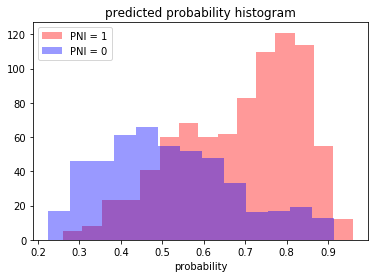

In [20]:
sns.distplot(df_pni_cv_rf[df_pni_cv_rf['PNI']==1]['probability'], color = 'red', kde = False)
sns.distplot(df_pni_cv_rf[df_pni_cv_rf['PNI']==0]['probability'], color = 'blue', kde = False)
plt.legend(['PNI = 1','PNI = 0'])
plt.title('predicted probability histogram')

## Analysis of SFS model - ROC - 21 features

In [21]:
feature_list = ['ANKUB1', 'ASPG', 'ATCAY', 'C4orf45', 'CFAP73', 'CNGA4', 'CNOT6', 'FBXO36', 'HNRNPA3', 'HSD3BP4', 'HSP90B1', 'HSPA4L', 'METTL15', 'PPP4R1', 'RBM25', 'SPDYE20P', 'SRGN', 'TNFAIP3', 'TSPAN8', 'UBE3A', 'ZMYM5']

In [22]:
X_sfs = X[feature_list]

In [23]:
X_sfs.shape

(1334, 21)

In [24]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 180)
model = RandomForestClassifier(n_estimators=100,
    max_depth=25,
    min_samples_leaf=3,
    verbose=0,
    random_state = 180)

cv = cross_validate(model, X = X_sfs, y = y, scoring = 'roc_auc', cv = cv_splitter)
cv

{'fit_time': array([0.50124884, 0.40637088, 0.362216  , 0.49016285, 0.70527411]),
 'score_time': array([0.01846623, 0.02549386, 0.0135231 , 0.04354119, 0.0169878 ]),
 'test_score': array([0.76283058, 0.78643884, 0.7877068 , 0.79712595, 0.81357897]),
 'train_score': array([0.99945898, 0.99935683, 0.99926603, 0.99939466, 0.99987547])}

In [25]:
for fold, (train_index, test_index) in enumerate(cv_splitter.split(X_sfs, y)):
    if fold == 4:
        X_train, X_test = X_sfs.iloc[train_index], X_sfs.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestClassifier(n_estimators=100,
                                        max_depth=25,
                                        min_samples_leaf=3,
                                        verbose=0,
                                        random_state = 180)
        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)[:,1]

        print(roc_auc_score(y_test,y_pred))

0.813578966632099


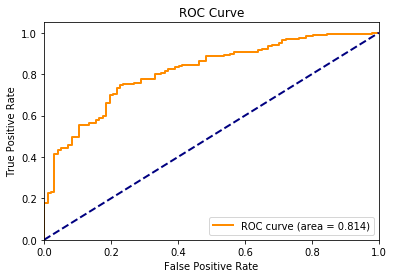

In [26]:
fpr, tpr, thres = roc_curve(y_test,y_pred)
plt = plot_roc(fpr,tpr)
plt.savefig('results/outputs_0714/roc_curve_pni_sfs_rf.png')

## Cross val prediction

In [27]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 180)
model = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=3, verbose=0, random_state = 180)

y_pred_cv_sfs_rf = cross_val_predict(model, X = X_sfs, y = y, cv = cv_splitter, method = 'predict_proba')[:,1]

In [28]:
df_pni_cv_sfs_rf = pd.DataFrame({
    'ID': df['ID'],
    'probability': y_pred_cv_sfs_rf,
    'PNI': y
})

df_pni_cv_sfs_rf.to_csv('results/outputs_0714/predicted_results_pni_sfs_rf.csv', index = False)

Text(0.5, 1.0, 'predicted probability histogram')

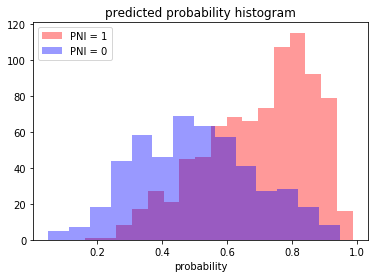

In [29]:
sns.distplot(df_pni_cv_sfs_rf[df_pni_cv_sfs_rf['PNI']==1]['probability'], color = 'red', kde = False)
sns.distplot(df_pni_cv_sfs_rf[df_pni_cv_sfs_rf['PNI']==0]['probability'], color = 'blue', kde = False)
plt.legend(['PNI = 1','PNI = 0'])
plt.title('predicted probability histogram')

<module 'matplotlib.pyplot' from '/Users/PeterC/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

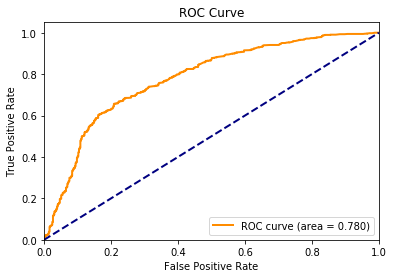

In [32]:
fpr, tpr, thres = roc_curve(y,y_pred_cv_rf)
plot_roc(fpr,tpr)